In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Modified this function from akl_knnClassifier.py
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
#     print(data["dependencies"][0])
    # Fix missing end parenthesis and extraneous initial spaces
    for i,deps in enumerate(data["dependencies"]):
        for j,dep in enumerate(deps):
            if len(dep)>0:
                if dep[len(dep)-1] != ')':
                    data["dependencies"][i][j] = dep+')'
                if dep[0] == ' ':
                    data["dependencies"][i][j] = data["dependencies"][i][j][1:]
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    # Fix missing end parenthesis and extraneous initial spaces
    for i,deps in enumerate(data["relevant_dependencies"]):
        for j,dep in enumerate(deps):
            if len(dep)>0:
                if dep[len(dep)-1] != ')':
                    data["relevant_dependencies"][i][j] = dep+')'
                if dep[0] == ' ':
                    data["relevant_dependencies"][i][j] = data["relevant_dependencies"][i][j][1:]
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data#.iloc[:40000,:], data.iloc[40000:,:]

data = read_data()

In [4]:
# Take a sentence index and a word and return a list of the dependencies containing that word; called by 
# dependencies_of_type function
def dependencies_with(sentence_index,word):
    depsWith = []
    for dependency in data['dependencies'][sentence_index]:
        if word in dependency:
            depsWith.append(dependency)
    return depsWith

# Take a sentence index, a word, and a type of dependency relation (for example, conj) and return a list of the 
# dependencies containing that word that are the given type
def dependencies_of_type(sentence_index,word,dep_type):
    depsOfType = []
    dependencies = dependencies_with(sentence_index,word)
    for dependency in dependencies:
        if dependency.split(' ')[0] == dep_type:# If first word in dependency (which should always be the type) is dep_type
            depsOfType.append(dependency)
    return depsOfType

In [14]:
# Identify sentences in which a gerund has a cc dependency
possible_pairs = []# Indices of the second gerund in each pair if that pair is connected by a cc
for index,gerund in enumerate(data['word']):#pair in sents:
    if dependencies_of_type(index,gerund,'cc') != []:
        possible_pairs.append(index)
print(len(possible_pairs), 'gerunds in a cc relation identified out of', len(data['word']), 'total gerunds.', 
     '(About', str(int(len(possible_pairs)/len(data['word'])*100))+'%)')

5258 gerunds in a cc relation identified out of 55059 total gerunds. (About 9%)


In [132]:
# Test if gerunds connected by cc are the same type
# This should also eliminate false instances such as those at index 652 and 11692

# Returns the word to which the given word is related by the conj dependency in the sentence at the given index
# If there is no such word, returns None
def getConjWord(index, word):
    for dependency in data["dependencies"][index]:
        dependency_split = dependency.split(' ')
        if dependency_split[0] == 'conj' and word in dependency_split[1]:
            return dependency_split[2].split('-')[0]
    return None

pairs = []# All pairs, excluding those where the conj word is not the previous gerund (false pairs)
triples = []# Possible groupings of three or more gerunds connected by a cc
pairs_mismatched = []# Pairs of two gerunds of different type
pairs_matched = []# Pairs of two gerunds of same type

mismatched_types = []# List of pairs of types that do not match

# Remove false pairs
for index in possible_pairs:
    conj_word = getConjWord(index, data['word'][index])
    if conj_word == data['word'][index-1]:
        pairs.append(index)
    elif conj_word == data['word'][index-1] or conj_word == data['word'][index-2] or conj_word == data['word'][index-3] or conj_word == data['word'][index-4] or conj_word == data['word'][index-5] or conj_word == data['word'][index-6]:
        triples.append(index)
#     elif conj_word != None and 'ing' in conj_word:
#         print(conj_word)

# Test if pairs are of same or different type
for index in pairs:
    if data['gerund_type'][index-1] != data['gerund_type'][index]:
        pairs_mismatched.append(index)
        mismatched_types.append([data['gerund_type'][index-1],data['gerund_type'][index]])
    else:
        pairs_matched.append(index)

# Print findings
print('\"False pairs\" refers to gerunds that are in a cc dependency but that are NOT in a conj dependency with another gerund (at least according to the classifications in the dataframe).')
num_eliminated = len(possible_pairs)-len(pairs_matched)-len(pairs_mismatched)-len(triples)
print(num_eliminated,'false pairs were eliminated out of', len(possible_pairs),'possible pairs.', 
      '(About', str(int(num_eliminated/len(possible_pairs)*100))+'%)')
print(len(pairs_matched),'pairs have the same gerund types out of',str(len(pairs)), 'pairs.', 
     '(About', str(int(len(pairs_matched)/len(pairs)*100))+'%)')
print(len(pairs_mismatched),'pairs have different gerund types out of',str(len(pairs)), 'pairs.', 
     '(About', str(int(len(pairs_mismatched)/len(pairs)*100))+'%)')
print(len(triples),'possible groupings of three or more connected gerunds were identified.')

"False pairs" refers to gerunds that are in a cc dependency but that are NOT in a conj dependency with another gerund (at least according to the classifications in the dataframe).
2972 false pairs were eliminated out of 5258 possible pairs. (About 56%)
1836 pairs have the same gerund types out of 2041 pairs. (About 89%)
205 pairs have different gerund types out of 2041 pairs. (About 10%)
245 possible groupings of three or more connected gerunds were identified.


In [133]:
typenames = ['vp-ing','acc-ing','poss-ing','det-ing','ing-of','poss-ing-of']

# Get counts and proportions (as decimals) of gerund types in indexList
def getCountsAndProportions(indexList):
    
    # Create list of the gerund types of the gerunds at the indices in indexList
    typeList = []
    for index in indexList:
        typeList.append(data['gerund_type'][index])
    
    counts = []
    proportions = []
    for typename in typenames:
        count = typeList.count(typename)
        proportion = count / len(typeList)
        counts.append(count)
        proportions.append(proportion)
        print('Proportion of '+typename+': \t'+str(proportion))
    return counts, proportions

In [134]:
# Get counts and proportions of gerund types in the whole dataframe

counts_in_dataframe, proportions_in_dataframe = getCountsAndProportions(range(len(data['word'])))

Proportion of vp-ing: 	0.7566428740078824
Proportion of acc-ing: 	0.10813854229099693
Proportion of poss-ing: 	0.02268475635227665
Proportion of det-ing: 	0.0537423491164024
Proportion of ing-of: 	0.05416008282024737
Proportion of poss-ing-of: 	0.004631395412194192


In [135]:
# Get counts and proportions of gerund types in matching pairs

counts_pairs_matched, proportions_pairs_matched = getCountsAndProportions(pairs_matched)

Proportion of vp-ing: 	0.9776688453159041
Proportion of acc-ing: 	0.009259259259259259
Proportion of poss-ing: 	0.0010893246187363835
Proportion of det-ing: 	0.007625272331154684
Proportion of ing-of: 	0.004357298474945534
Proportion of poss-ing-of: 	0.0


In [136]:
# Create graph by gerund type given counts or proportions
# datalist is the list of indices of gerunds to be graphed
# title is the title of the graph
# ylabel should normally be 'Count' or 'Proportion'

def graphByGerundType(countsOrProportions,title,ylabel):
    fig = plt.figure(figsize = (10, 5))
    plt.bar(typenames, countsOrProportions, color ='red', width = 0.4)
    plt.xlabel('Gerund Type')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

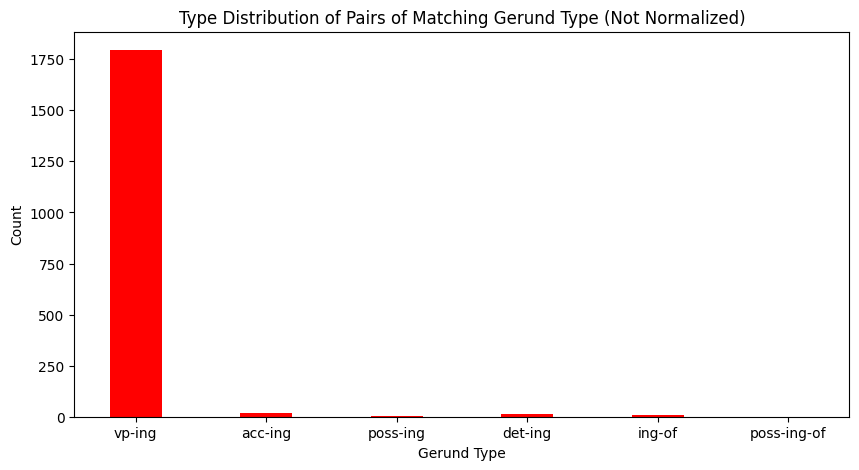

In [137]:
graphByGerundType(counts_pairs_matched,'Type Distribution of Pairs of Matching Gerund Type (Not Normalized)','Count')

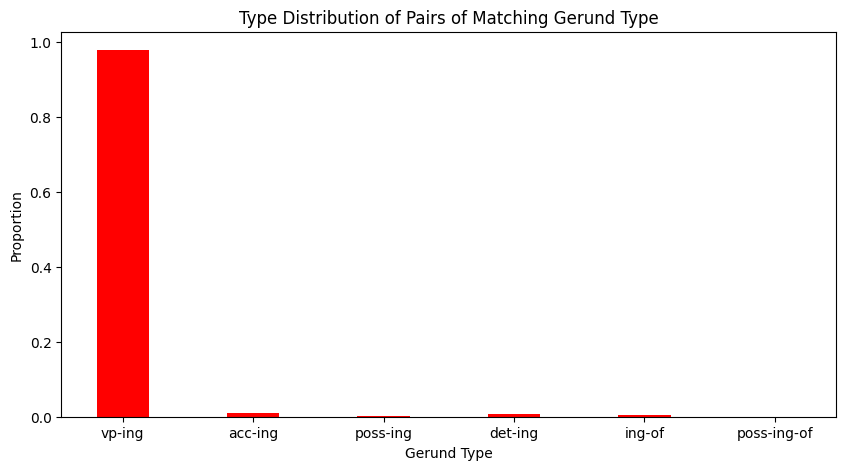

In [138]:
graphByGerundType(proportions_pairs_matched,'Type Distribution of Pairs of Matching Gerund Type','Proportion')

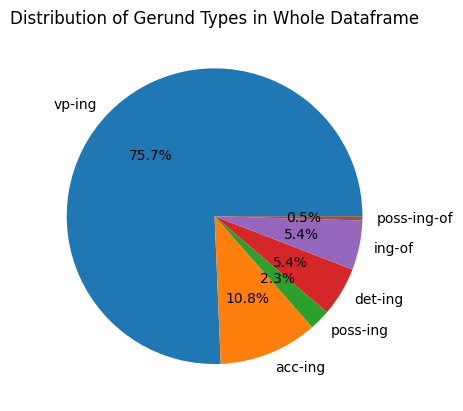

In [168]:
# Create pie chart showing the distribution of gerund types in the whole dataframe

plt.pie(proportions_in_dataframe, labels=typenames, autopct='%1.1f%%')
plt.title('Distribution of Gerund Types in Whole Dataframe')
plt.show()

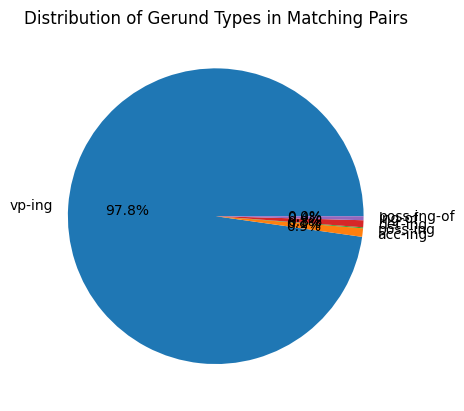

In [167]:
# Create pie chart showing the distribution of gerund types in matching pairs

plt.pie(proportions_pairs_matched, labels=typenames, autopct='%1.1f%%')
plt.title('Distribution of Gerund Types in Matching Pairs')
plt.show()

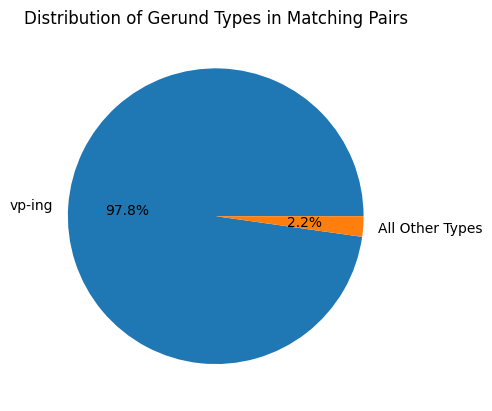

In [141]:
# Create the above pie chart but merge everything other than vp-ing

plt.pie([proportions_pairs_matched[0],1-proportions_pairs_matched[0]], labels=['vp-ing','All Other Types'], autopct='%1.1f%%')
plt.title('Distribution of Gerund Types in Matching Pairs')
plt.show()

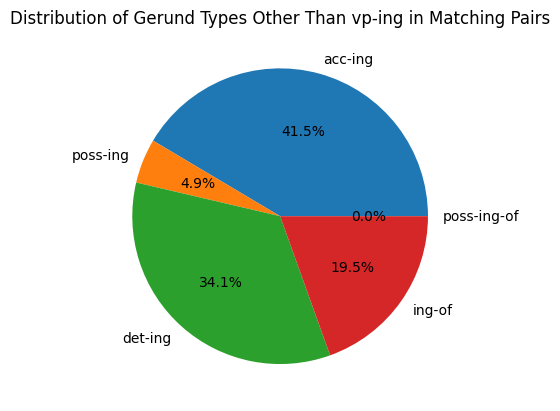

In [142]:
# Create pie chart showing the breakdown of "All Other Types" from above pie chart

plt.pie(proportions_pairs_matched[1:], labels=typenames[1:], autopct='%1.1f%%')
plt.title('Distribution of Gerund Types Other Than vp-ing in Matching Pairs')
plt.show()

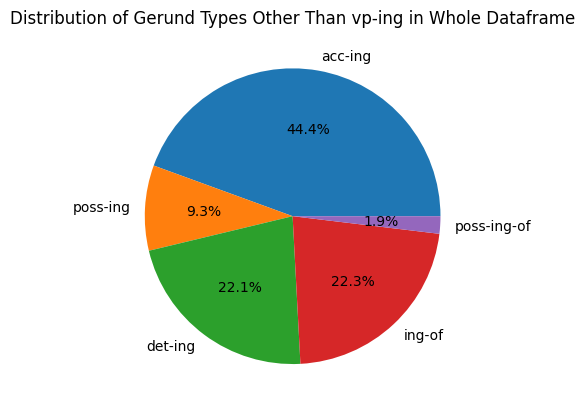

In [143]:
# Create pie chart showing the breakdown of "All Other Types" but in whole Dataframe

plt.pie(proportions_in_dataframe[1:], labels=typenames[1:], autopct='%1.1f%%')
plt.title('Distribution of Gerund Types Other Than vp-ing in Whole Dataframe')
plt.show()

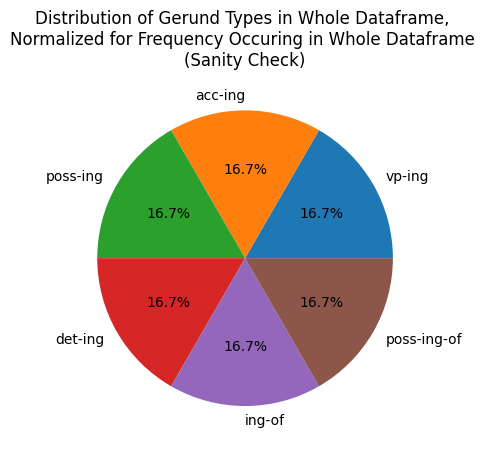

In [144]:
# Create pie chart showing the distribution of gerund types in whole dataframe normalized for frequency of that type in the dataframe
# Not a useful graph, just a sanity check

plt.pie(np.array(counts_in_dataframe)/np.array(counts_in_dataframe), labels=typenames, autopct='%1.1f%%')
plt.title('Distribution of Gerund Types in Whole Dataframe, \nNormalized for Frequency Occuring in Whole Dataframe \n(Sanity Check)')
plt.show()

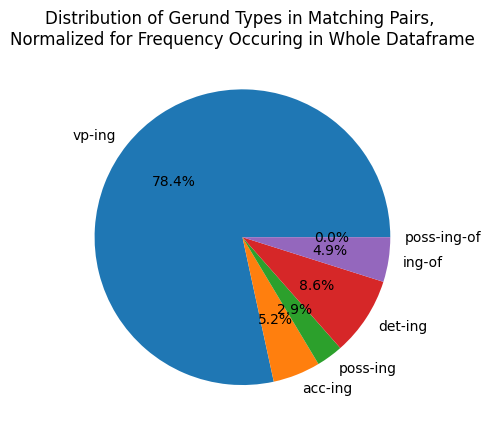

In [145]:
# Create pie chart showing the distribution of gerund types in matching pairs normalized for frequency of that type in the dataframe

plt.pie(np.array(counts_pairs_matched)/np.array(counts_in_dataframe), labels=typenames, autopct='%1.1f%%')
plt.title('Distribution of Gerund Types in Matching Pairs, \nNormalized for Frequency Occuring in Whole Dataframe')
plt.show()

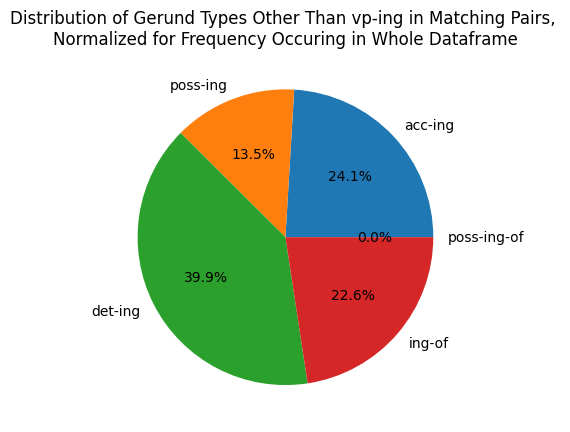

In [146]:
# Create pie chart showing the distribution of gerund types in matching pairs normalized for frequency of that type in the dataframe, excluding vp-ing

plt.pie(np.array(counts_pairs_matched[1:])/np.array(counts_in_dataframe[1:]), labels=typenames[1:], autopct='%1.1f%%')
plt.title('Distribution of Gerund Types Other Than vp-ing in Matching Pairs, \nNormalized for Frequency Occuring in Whole Dataframe')
plt.show()

In [154]:
# Get list of mismatched types (without duplicates in the list), not differentiating for order in pair
mismatched_types_unique = []
for pair in mismatched_types:
    if pair not in mismatched_types_unique and [pair[1],pair[0]] not in mismatched_types_unique:
        mismatched_types_unique.append(pair)

# Get number of occurrences and proportions (as decimals) of each pair of mismatched types, not differentiating for order in pair
mismatched_types_unique_counts = []# Counts of occurrences of each unique mismatched type
mismatched_types_unique_proportions = []# Proportions of each unique mismatched type
for pair in mismatched_types_unique:
    mtu_count = mismatched_types.count(pair) + mismatched_types.count([pair[1],pair[0]])
    mtu_proportion = mtu_count / len(mismatched_types)
    mismatched_types_unique_counts.append(mtu_count)
    mismatched_types_unique_proportions.append(mtu_proportion)
    print('Count of'+str(pair)+': '+str(mtu_count))

Count of['det-ing', 'vp-ing']: 22
Count of['acc-ing', 'vp-ing']: 113
Count of['det-ing', 'ing-of']: 8
Count of['vp-ing', 'ing-of']: 49
Count of['poss-ing', 'vp-ing']: 6
Count of['poss-ing', 'ing-of']: 2
Count of['acc-ing', 'det-ing']: 1
Count of['acc-ing', 'ing-of']: 2
Count of['poss-ing', 'poss-ing-of']: 2


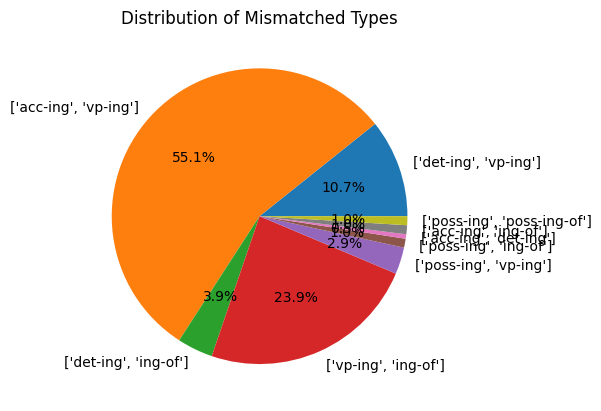

In [156]:
# Create pie chart showing the distribution of mismatched types

plt.pie(mismatched_types_unique_proportions, labels=mismatched_types_unique, autopct='%1.1f%%')
plt.title('Distribution of Mismatched Types')
plt.show()

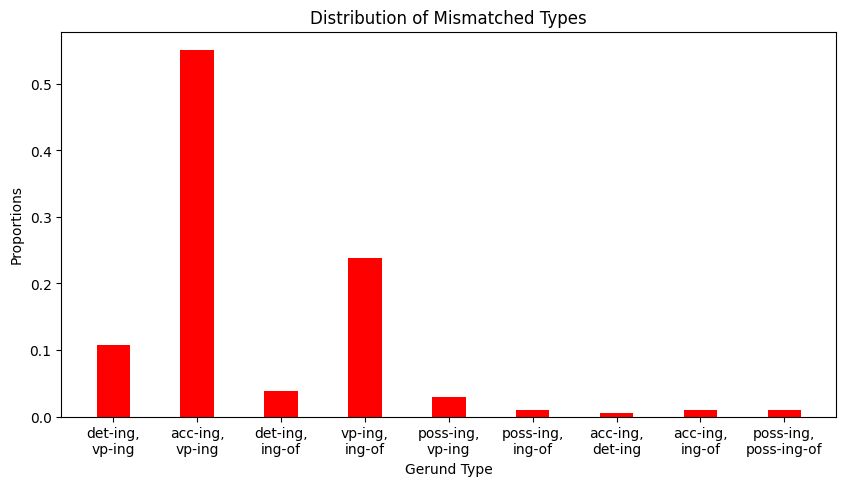

In [162]:
# Create bar graph showing the distribution of mismatched types

mismatched_types_unique_as_strings = []
for pair in mismatched_types_unique:
    mismatched_types_unique_as_strings.append(str(pair[0])+',\n'+str(pair[1]))

fig = plt.figure(figsize = (10, 5))
plt.bar(mismatched_types_unique_as_strings, mismatched_types_unique_proportions, color='red', width=0.4)
plt.xlabel('Gerund Type')
plt.ylabel('Proportions')
plt.title('Distribution of Mismatched Types')
plt.show()